# Project Analysis using Thicket

In [37]:
import sys
# sys.path.append("/scratch/group/csce435-f23/python-3.8.17/lib/python3.8/site-packages")
# sys.path.append("/scratch/group/csce435-f23/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket.thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

#### Cali File Generation
- Strong Scaling Data: random input type, all thread/process counts, all input sizes
- Weak Scaling Data: run_weak_CUDA/MPI()
- Input Types Data: all input types, all thread/process counts, $2^{20}$ input size
- Merge Sort: lower input size values

### Read in all the files

In [38]:
tk_cuda_random = th.Thicket.from_caliperreader(glob("cuda_trial/random/*.cali"))
tk_cuda_2_20 = th.Thicket.from_caliperreader(glob("cuda_trial/2_20/*.cali"))
tk_cuda_weak = th.Thicket.from_caliperreader(glob("cuda_trial/weak/*.cali"))
tk_mpi_random = th.Thicket.from_caliperreader(glob("mpi_trial/random/*.cali"))
tk_mpi_2_20 = th.Thicket.from_caliperreader(glob("mpi_trial/2_20/*.cali"))
tk_mpi_weak = th.Thicket.from_caliperreader(glob("mpi_trial/weak/*.cali"))
tk_seq = th.Thicket.from_caliperreader(glob("seq_trial/*.cali"))

In [39]:
# checking data
# tk_cuda_random.metadata
# tk_mpi_random.metadata
# tk_seq.metadata

In [40]:
# checking call trees
tk_cuda_2_20.statsframe.dataframe["time"] = 1
tk_mpi_random.statsframe.dataframe["time"] = 1
tk_mpi_2_20.statsframe.dataframe["time"] = 1
tk_mpi_weak.statsframe.dataframe["time"] = 1
tk_seq.statsframe.dataframe["time"] = 1
# print(tk_cuda_2_20.tree())
# print(tk_mpi_weak.tree())
# print(tk_seq.tree())

### Group and Clean Data

#### Sequential Data

In [41]:
# group and concat
gb_seq = tk_seq.groupby("InputSize")
ctk_seq = th.Thicket.concat_thickets(
    thickets=list(gb_seq.values()),
    headers=list(gb_seq.keys()),
    axis="columns",
    metadata_key="InputType"
)

# clean dataframe
ctk_seq.dataframe = ctk_seq.dataframe.reset_index().drop([("node", ""), (65536, "nid"), (65536, "spot.channel"), 
                                                  (65536, "Min time/rank"), (65536, "Max time/rank"), (65536, "Avg time/rank"), 
                                                  (1048576, "nid"), (1048576, "spot.channel"), (1048576, "Min time/rank"), 
                                                  (1048576, "Max time/rank"), (1048576, "Avg time/rank")], axis=1)
ctk_seq.dataframe = ctk_seq.dataframe.rename({("name", ""): "name", ("InputType", ""): "InputType"}).set_index(["name", "InputType"])
# ctk_seq.dataframe

2  thickets created...
{65536: <thicket.thicket.Thicket object at 0x000002BA0B46E6E0>, 1048576: <thicket.thicket.Thicket object at 0x000002BA0CFACBB0>}


#### CUDA Data

In [42]:
drop_cuda_columns = ["nid", "spot.channel", "Min time/rank", "Max time/rank", "Avg time/rank",
                     "Min GPU time/rank", "Max GPU time/rank", "Avg GPU time/rank", "Total GPU time"]
thread_size = sorted(list(set(tk_cuda_weak.metadata["num_blocks"])))
input_sizes = sorted(list(set(tk_cuda_random.metadata["InputSize"])))
input_types = sorted(list(set(tk_cuda_2_20.metadata["InputType"])))

##### Strong Scaling Data

In [43]:
# group and concat
gb_cuda_random = tk_cuda_random.groupby("InputSize")
ctk_cuda_random = th.Thicket.concat_thickets(
    thickets=list(gb_cuda_random.values()),
    headers=list(gb_cuda_random.keys()),
    axis="columns",
    metadata_key="num_threads"
)

# clean dataframe
drop_column_list = [(s, c) for s in input_sizes for c in drop_cuda_columns]
drop_column_list.append(("node", ""))
ctk_cuda_random.dataframe = ctk_cuda_random.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_random.dataframe = ctk_cuda_random.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
# ctk_cuda_random.dataframe

3  thickets created...
{65536: <thicket.thicket.Thicket object at 0x000002BA0621D690>, 1048576: <thicket.thicket.Thicket object at 0x000002BA0C408D00>, 16777216: <thicket.thicket.Thicket object at 0x000002BA0C3E55D0>}


##### Weak Scaling Data

In [44]:
# group and concat
gb_cuda_weak = tk_cuda_weak.groupby("num_blocks")
ctk_cuda_weak = th.Thicket.concat_thickets(
    thickets=list(gb_cuda_weak.values()),
    headers=list(gb_cuda_weak.keys()),
    axis="columns",
    metadata_key="num_threads"
)

# clean dataframe
drop_column_list = [(s, c) for s in thread_size for c in drop_cuda_columns]
drop_column_list.append(("node", ""))
ctk_cuda_weak.dataframe = ctk_cuda_weak.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_weak.dataframe = ctk_cuda_weak.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
# ctk_mpi_weak.dataframe

3  thickets created...
{64: <thicket.thicket.Thicket object at 0x000002BA0B3C4490>, 1024: <thicket.thicket.Thicket object at 0x000002BA08912FE0>, 16384: <thicket.thicket.Thicket object at 0x000002BA0CFDBA30>}


##### Input Types Data

In [45]:
# group and concat
gb_cuda_2_20 = tk_cuda_2_20.groupby("InputType")
ctk_cuda_2_20 = th.Thicket.concat_thickets(
    thickets=list(gb_cuda_2_20.values()),
    headers=list(gb_cuda_2_20.keys()),
    axis="columns",
    metadata_key="num_threads"
)

# clean dataframe
drop_column_list = [(t, c) for t in input_types for c in drop_cuda_columns]
drop_column_list.append(("node", ""))
ctk_cuda_2_20.dataframe = ctk_cuda_2_20.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_2_20.dataframe = ctk_cuda_2_20.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
# ctk_cuda_2_20.dataframe

4  thickets created...
{'nearly': <thicket.thicket.Thicket object at 0x000002BA089D1CC0>, 'random': <thicket.thicket.Thicket object at 0x000002BA0CB49000>, 'reverse': <thicket.thicket.Thicket object at 0x000002BA08ABA8F0>, 'sorted': <thicket.thicket.Thicket object at 0x000002BA0C896980>}


#### MPI Data

In [46]:
# common variables
drop_mpi_columns = ["nid", "spot.channel", "Min time/rank", "Max time/rank", "Variance time/rank", 
                    "Total time", "Retiring", "Backend bound", "Frontend bound", "Bad speculation"]
rank_size = sorted(list(set(tk_mpi_weak.metadata["local_size"])))

##### Strong Scaling Data

In [47]:
# group and concat
gb_mpi_random = tk_mpi_random.groupby("InputSize")
ctk_mpi_random = th.Thicket.concat_thickets(
    thickets=list(gb_mpi_random.values()),
    headers=list(gb_mpi_random.keys()),
    axis="columns",
    metadata_key="num_procs"
)

# clean dataframe
drop_column_list = [(s, c) for s in input_sizes for c in drop_mpi_columns]
drop_column_list.append(("node", ""))
ctk_mpi_random.dataframe = ctk_mpi_random.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_random.dataframe = ctk_mpi_random.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
# ctk_mpi_random.dataframe

3  thickets created...
{65536: <thicket.thicket.Thicket object at 0x000002BA0B3F1180>, 1048576: <thicket.thicket.Thicket object at 0x000002BA05FE17B0>, 16777216: <thicket.thicket.Thicket object at 0x000002BA0C828460>}


##### Weak Scaling Data

In [48]:
# group and concat
gb_mpi_weak = tk_mpi_weak.groupby("local_size")
ctk_mpi_weak = th.Thicket.concat_thickets(
    thickets=list(gb_mpi_weak.values()),
    headers=list(gb_mpi_weak.keys()),
    axis="columns",
    metadata_key="num_procs"
)

# clean dataframe
drop_column_list = [(s, c) for s in rank_size for c in drop_mpi_columns]
drop_column_list.append(("node", ""))
ctk_mpi_weak.dataframe = ctk_mpi_weak.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_weak.dataframe = ctk_mpi_weak.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
# ctk_mpi_weak.dataframe

3  thickets created...
{512: <thicket.thicket.Thicket object at 0x000002BA0BF4A0B0>, 8192: <thicket.thicket.Thicket object at 0x000002BA0C828DF0>, 131072: <thicket.thicket.Thicket object at 0x000002BA0C44B550>}


##### Input Type Data

In [49]:
# group and concat
gb_mpi_2_20 = tk_mpi_2_20.groupby("InputType")
ctk_mpi_2_20 = th.Thicket.concat_thickets(
    thickets=list(gb_mpi_2_20.values()),
    headers=list(gb_mpi_2_20.keys()),
    axis="columns",
    metadata_key="num_procs"
)

# clean dataframe
drop_column_list = [(t, c) for t in input_types for c in drop_mpi_columns]
drop_column_list.append(("node", ""))
ctk_mpi_2_20.dataframe = ctk_mpi_2_20.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_2_20.dataframe = ctk_mpi_2_20.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
# ctk_mpi_2_20.dataframe

4  thickets created...
{'nearly': <thicket.thicket.Thicket object at 0x000002BA0B711CC0>, 'random': <thicket.thicket.Thicket object at 0x000002BA08A96140>, 'reverse': <thicket.thicket.Thicket object at 0x000002BA0B41F820>, 'sorted': <thicket.thicket.Thicket object at 0x000002BA0D5A2740>}


### Plotting

#### Plot Functions

In [50]:
# Define common variables
threads = sorted(list(set(ctk_cuda_weak.dataframe.index.get_level_values("num_threads"))))
procs = sorted(list(set(ctk_mpi_weak.dataframe.index.get_level_values("num_procs"))))

In [74]:
def plot_strong(x, y, title, xlabel):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y, marker='o')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Speedup")
    plt.grid(True)
    plt.xscale("log", base=2)
    plt.show()
    return fig, ax

In [69]:
def plot_weak(df, title, xlabel, ylabel, legend):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(df, marker='o')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel + " (seconds)")
    ax.legend(legend, title="Elements per Process")
    plt.grid(True)
    plt.xscale("log", base=2)
    plt.show()
    return fig, ax

In [53]:
def plot_inputs(df, title, xlabel, ylabel):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(df, marker='o')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel + " (seconds)")
    ax.legend(input_types)
    plt.grid(True)
    plt.xscale("log", base=2)
    plt.show()
    return fig, ax

In [68]:
def plot_comm_comp(x, comm, comp, title, xlabel):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, comm, marker='o')
    ax.plot(x, comp, marker='o')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Percentage of Runtime (%)")
    ax.legend(["comm", "comp"])
    plt.grid(True)
    plt.xscale("log", base=2)
    plt.show()
    return fig, ax

#### Graphs

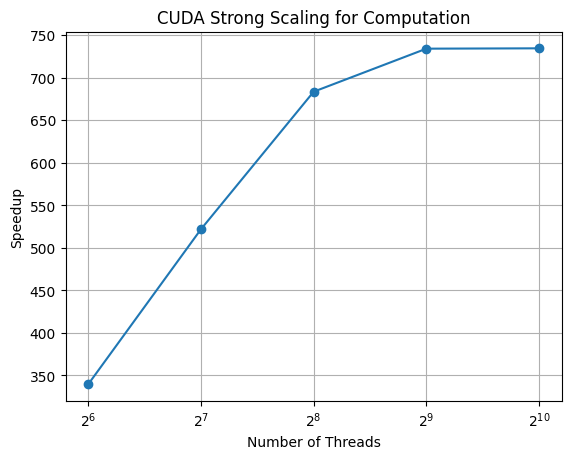

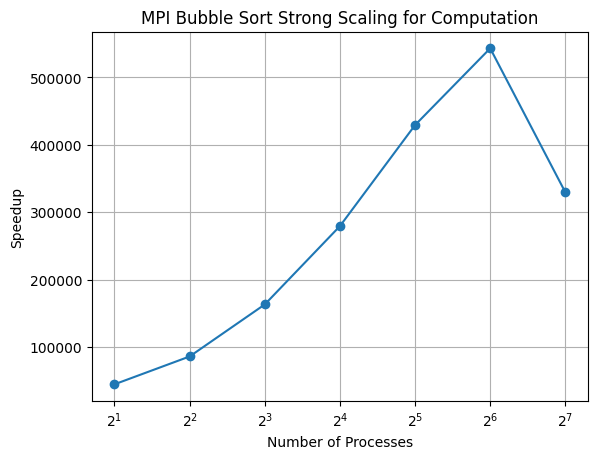

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MPI Bubble Sort Strong Scaling for Computation'}, xlabel='Number of Processes', ylabel='Speedup'>)

In [75]:
# strong scaling
t1_comp = ctk_seq.dataframe[1048576]["Total time"]["comp"]["random"]
speedup_cuda_comp = [t1_comp/ctk_cuda_random.dataframe[1048576]["Total time"]["comp"][t] for t in threads]
speedup_mpi_comp = [t1_comp/ctk_mpi_random.dataframe[1048576]["Avg time/rank"]["comp"][p] for p in procs]

plot_strong(threads, speedup_cuda_comp, "CUDA Strong Scaling for Computation", "Number of Threads")
plot_strong(procs, speedup_mpi_comp, "MPI Bubble Sort Strong Scaling for Computation", "Number of Processes")

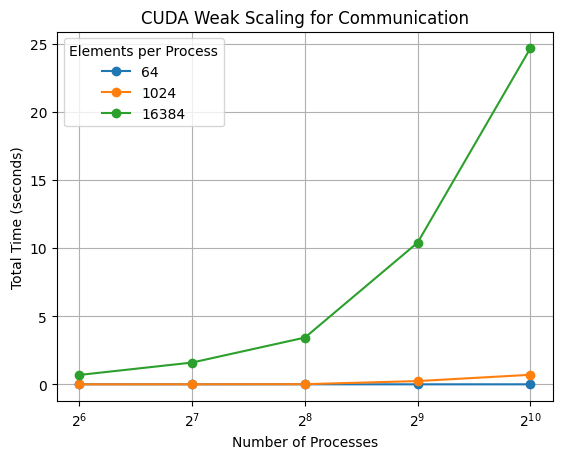

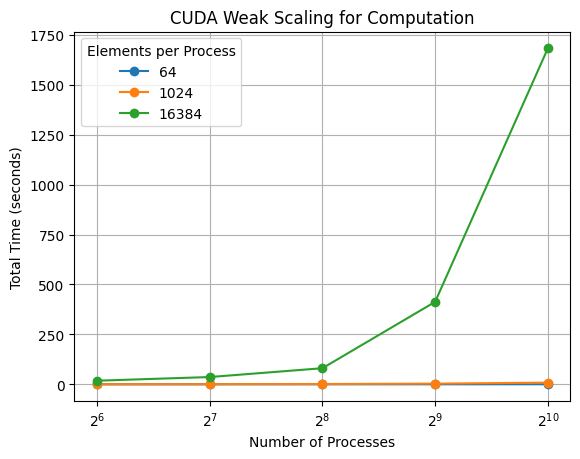

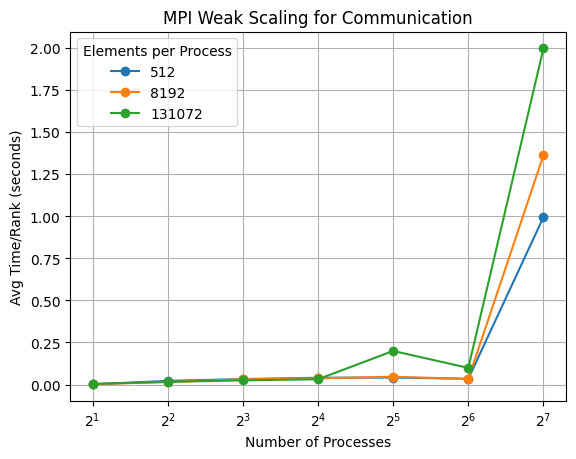

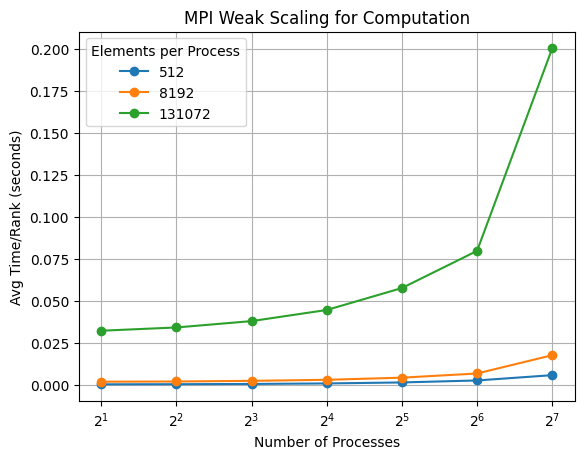

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MPI Weak Scaling for Computation'}, xlabel='Number of Processes', ylabel='Avg Time/Rank (seconds)'>)

In [57]:
# weak scaling
plot_weak(ctk_cuda_weak.dataframe.loc["comm"], "CUDA Weak Scaling for Communication", "Number of Processes", "Total Time", thread_size)
plot_weak(ctk_cuda_weak.dataframe.loc["comp"], "CUDA Weak Scaling for Computation", "Number of Processes", "Total Time", thread_size)
plot_weak(ctk_mpi_weak.dataframe.loc["comm"], "MPI Weak Scaling for Communication", "Number of Processes", "Avg Time/Rank", rank_size)
plot_weak(ctk_mpi_weak.dataframe.loc["comp"], "MPI Weak Scaling for Computation", "Number of Processes", "Avg Time/Rank", rank_size)

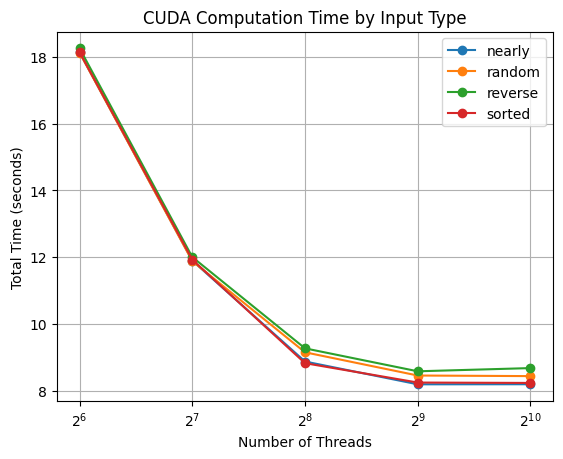

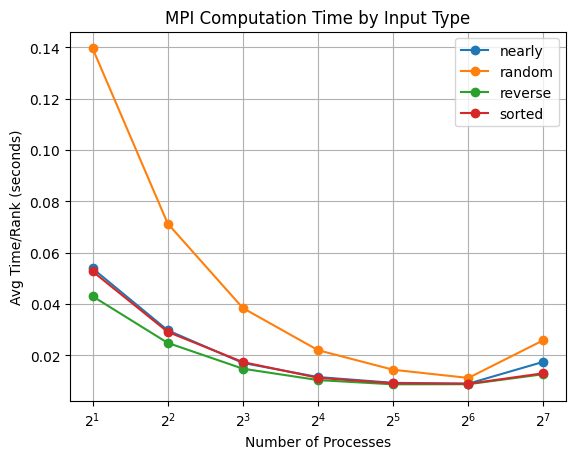

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MPI Computation Time by Input Type'}, xlabel='Number of Processes', ylabel='Avg Time/Rank (seconds)'>)

In [58]:
# comparing by input types
plot_inputs(ctk_cuda_2_20.dataframe.loc["comp"], "CUDA Computation Time by Input Type", "Number of Threads", "Total Time")
plot_inputs(ctk_mpi_2_20.dataframe.loc["comp"], "MPI Computation Time by Input Type", "Number of Processes", "Avg Time/Rank")

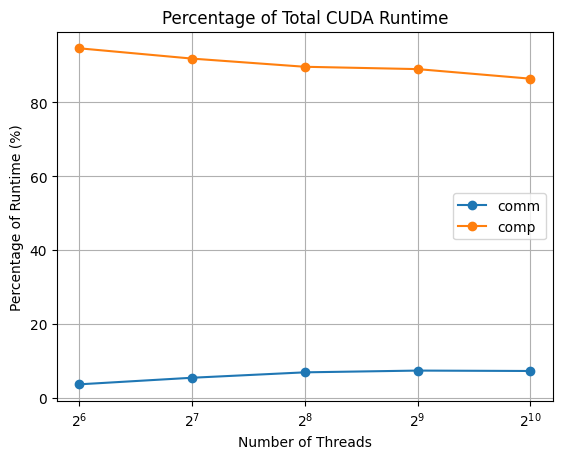

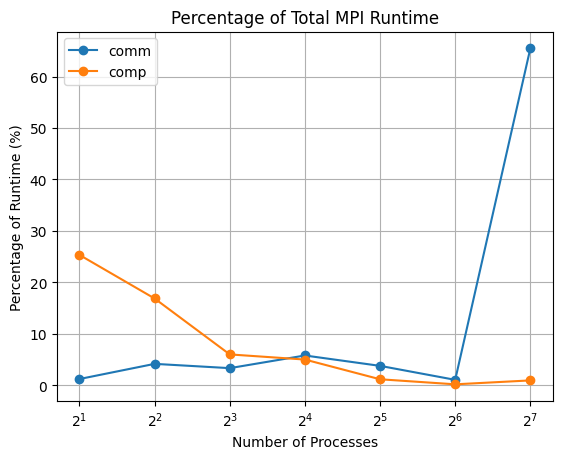

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Percentage of Total MPI Runtime'}, xlabel='Number of Processes', ylabel='Percentage of Runtime (%)'>)

In [59]:
# comparing comm and comp times
comm_per_cuda = [ctk_cuda_random.dataframe[1048576]["Total time"]["comm"][t] / ctk_cuda_random.dataframe[1048576]["Total time"]["main"][t] * 100 for t in threads]
comp_per_cuda = [ctk_cuda_random.dataframe[1048576]["Total time"]["comp"][t] / ctk_cuda_random.dataframe[1048576]["Total time"]["main"][t] * 100 for t in threads]
comm_per_mpi = [ctk_mpi_random.dataframe[1048576]["Avg time/rank"]["comm"][p] / ctk_mpi_random.dataframe[1048576]["Avg time/rank"]["main"][p] * 100 for p in procs]
comp_per_mpi = [ctk_mpi_random.dataframe[1048576]["Avg time/rank"]["comp"][p] / ctk_mpi_random.dataframe[1048576]["Avg time/rank"]["main"][p] * 100 for p in procs]

plot_comm_comp(threads, comm_per_cuda, comp_per_cuda, "Percentage of Total CUDA Runtime", "Number of Threads")
plot_comm_comp(procs, comm_per_mpi, comp_per_mpi, "Percentage of Total MPI Runtime", "Number of Processes")